In [1]:
import math as m
import numpy as np
import scipy.optimize as o

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### PARAM: Initial player or pearl position
s_x0 = 0
s_y0 = 4
s_z0 = 0

s_y0 = s_y0 + 1.62 - 0.1

In [3]:
### PARAM: Initial player velocity
v_px = 0
v_py = 0
v_pz = 0

In [4]:
### Initial velocity at desired axis given a pitch. Yaw is kept constant to 360 degrees. 
def v_0(axis:str, pitch:float) -> float:
    pitch = m.radians(pitch)
    return {
        "x": 0,
        "y": -1.5 * m.sin(pitch),
        "z": 1.5 * m.cos(pitch)
    }[axis]

In [5]:
### Component-wise velocity function given axis, initial pitch, and time. We keep yaw constant at 360 degrees
def v(t:int, axis:str, pitch:float) -> float:
    pitch = m.radians(pitch)
    return {
        "x": v_0(axis, pitch)*0.99**m.floor(t), 
        "y": v_0(axis, pitch)*0.99**m.floor(t) - 0.03*(100-100*0.99**m.floor(t)),
        "z": v_0(axis, pitch)*0.99**m.floor(t)
    }[axis]

In [6]:
### Component-wise position function. We keep yaw constant at 360 degrees (hence, zeroing every sin(yaw))
def s(t:int, axis:str, pitch:float) -> float:
    pitch = m.radians(pitch)
    return {
        "x": s_x0,
        "y": s_y0 - 3*t - (1.5*m.sin(pitch) - 3) * (100 - 100*0.99**t),
        "z": s_z0 + 1.5*m.cos(pitch) * (100 - 100*0.99**t)
    }[axis]

In [7]:
### Passed into root_scalar to find where the position function for y, ie s_y, intersects the even ground y=s_y0. This helper transforms the root found by root_scalar to be the solution to s_y = s_y0 (where s_y0 is adjusted for the 1.62 and -0.1 offsets applied its initialization). 
def helper_s_y(t:int, pitch:float) -> float:
    return s(t, "y", pitch) - (s_y0 - (1.62-0.1))

In [8]:
### Compute when the pearl hits the ground, ASSUMING the landing spot is level with the player's standing spot 
# upper bound seems to be at least 90 ticks, as produced by angle -89 to -84 (angle -83 produced 89 ticks). Hence, 300 as an upper bound on root-finding is more than enough.  
def compute_landing_time(pitch:float) -> float:
    return m.floor(o.root_scalar(helper_s_y, args=(pitch), bracket=[0, 300], method="bisect").root)

In [9]:
landing_times = {}
landing_spots_z = {}
grain = 0.1  #0.00000001: -37.98 to -37.973683
#for pitch in np.arange(-90, 0.001, grain):
#    landing_times[pitch] = (compute_landing_time(pitch))
#    landing_spots_z[pitch] = s(landing_times[pitch], "z", pitch)

for k in range(-16384, 0):
    pitch = k * 360/65536
    landing_times[pitch] = compute_landing_time(pitch)
    landing_spots_z[pitch] = s(landing_times[pitch], "z", pitch)

landing_spots_z, len(landing_spots_z)

({-90.0: 5.429898608354366e-15,
  -89.9945068359375: 0.008501798374062362,
  -89.989013671875: 0.017003596669952895,
  -89.9835205078125: 0.025505394809569714,
  -89.97802734375: 0.03400719271474641,
  -89.9725341796875: 0.04250899030731661,
  -89.967041015625: 0.05101078750917297,
  -89.9615478515625: 0.059512584242149134,
  -89.9560546875: 0.06801438042807871,
  -89.9505615234375: 0.07651617598885437,
  -89.945068359375: 0.08501797084630977,
  -89.9395751953125: 0.09351976492229823,
  -89.93408203125: 0.10202155813865339,
  -89.9285888671875: 0.11052335041726798,
  -89.923095703125: 0.11902514167997565,
  -89.9176025390625: 0.12752693184861008,
  -89.912109375: 0.136028720845064,
  -89.9066162109375: 0.14453050859117111,
  -89.901123046875: 0.15303229500878485,
  -89.8956298828125: 0.16153408001973885,
  -89.89013671875: 0.17003586354592595,
  -89.8846435546875: 0.17853764550917986,
  -89.879150390625: 0.1870394258313344,
  -89.8736572265625: 0.19554120443428233,
  -89.8681640625: 0.

In [10]:
landing_spots_z.loc[8000:8010]

AttributeError: 'dict' object has no attribute 'loc'

In [12]:
df = pd.DataFrame.from_dict(landing_spots_z, orient='index').reset_index()
df.columns = columns=['Pitch', 'Distance']
df['Pitch'] = df['Pitch']#.round(1)
df['Distance'] = df['Distance'].apply(lambda x: '{:.6f}'.format(x)).astype(float)
pd.options.display.float_format = None
df = df.reset_index(drop = True)
df

,Pitch,Distance
0,-90.000000,0.000000
1,-89.994507,0.008502
2,-89.989014,0.017004
3,-89.983521,0.025505
4,-89.978027,0.034007
...,...,...
16379,-0.027466,14.342687
16380,-0.021973,14.342688
16381,-0.016479,14.342688
16382,-0.010986,14.342688


In [ ]:
df.loc[8000:8010]

,Pitch,Distance
8000,-46.054688,51.008386
8001,-46.049194,51.013460
8002,-46.043701,51.018533
8003,-46.038208,51.023605
8004,-46.032715,51.028678
8005,-46.027222,51.033749
8006,-46.021729,51.038821
8007,-46.016235,51.043891
8008,-46.010742,51.048962
8009,-46.005249,51.054031


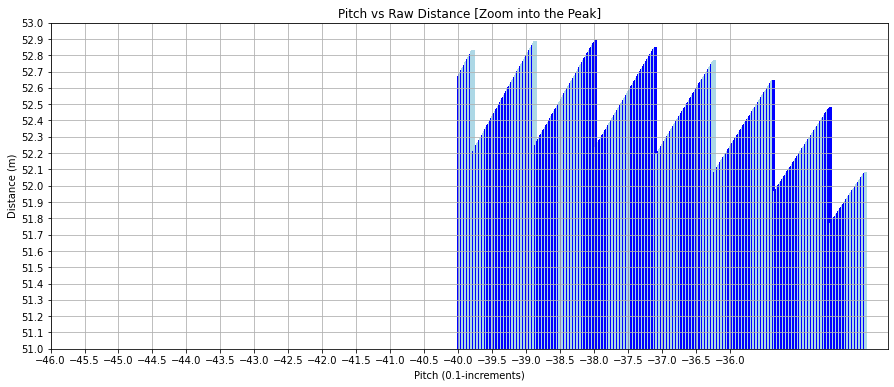

In [13]:
plt.figure(figsize=(15,6))
zoomed_df = df[(df['Pitch'] >= -40.) & (df['Pitch'] <= -34.)]

plt.bar(zoomed_df['Pitch'], zoomed_df['Distance'], color=['blue', 'lightblue'], width=0.05)
plt.xticks(np.arange(-46, -36+0.1, 0.5))
plt.yticks(np.arange(51, 53+0.1, 0.1))
plt.ylim(51, 53)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Distance (m)')
plt.title('Pitch vs Raw Distance [Zoom into the Peak]')
plt.grid(True)

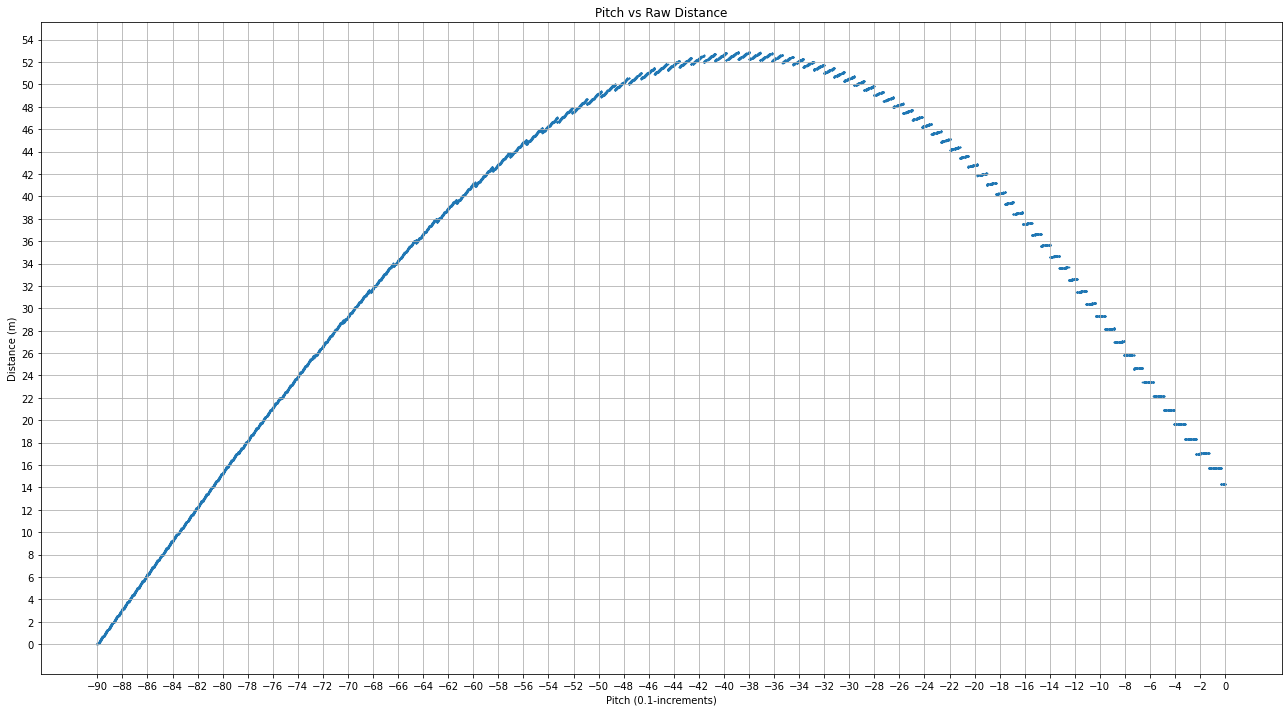

In [ ]:
plt.figure(figsize=(18,10))

plt.scatter(df['Pitch'], df['Distance'], s=0.6)
plt.xticks(np.arange(-90, 0+0.1, 2))
plt.yticks(np.arange(0, 54+0.1, 2))
#plt.ylim(51, 53)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Distance (m)')
plt.title('Pitch vs Raw Distance')
plt.grid(True)
plt.tight_layout()
#plt.margins(x=0)

In [ ]:
# Generated with np.arange(-37.98, -37.973683, 0.00000001)
top_10_entries = dict(sorted(landing_spots_z.items(), key=lambda item: item[1], reverse=True)[:10])
top_10_entries

{-37.9742431640625: 52.89209945925462,
 -37.979736328125: 52.88814101272806,
 -38.86962890625: 52.885939185946924,
 -37.9852294921875: 52.884182080065074,
 -38.8751220703125: 52.88185210098631,
 -37.99072265625: 52.880222661302035,
 -38.880615234375: 52.87776452994706,
 -37.9962158203125: 52.876262756475334,
 -38.8861083984375: 52.873676472866755,
 -38.001708984375: 52.87230236562137}

In [ ]:
### Increments of 0.1 and of zoomed graph -- plotting landing times
landing_times_2 = {}
for pitch in np.arange(-40, -34, 0.1):
    landing_times_2[pitch] = compute_landing_time(pitch)

tf = pd.DataFrame.from_dict(landing_times_2, orient='index').reset_index()
tf.columns = columns=['Pitch', 'Airtime']
tf['Pitch'] = tf['Pitch'].round(1)
#tf['Airtime'] = df['Airtime'].apply(lambda x: '{:.6f}'.format(x)).astype(float)
pd.options.display.float_format = None
tf = tf.reset_index(drop = True)
tf.describe()

,Pitch,Airtime
count,60.000000,60.000000
mean,-37.050000,57.433333
std,1.746425,2.053246
min,-40.000000,54.000000
25%,-38.525000,56.000000
50%,-37.050000,57.500000
75%,-35.575000,59.000000
max,-34.100000,61.000000


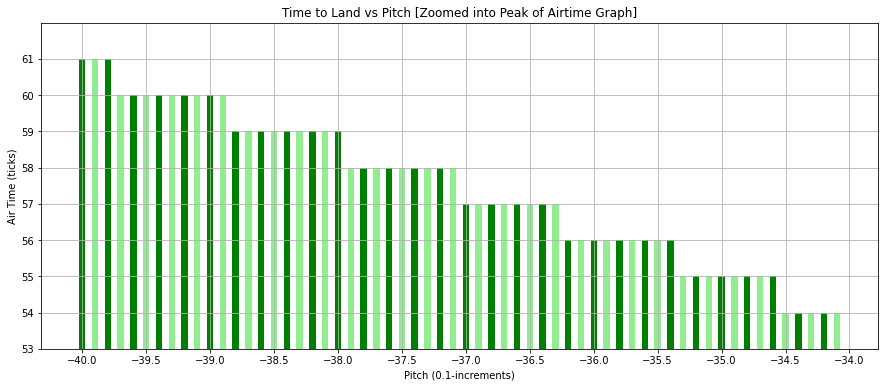

In [ ]:
plt.figure(figsize=(15,6))

plt.bar(tf['Pitch'], tf['Airtime'], color=['green', 'lightgreen'], width=0.05)
plt.xticks(np.arange(-40, -34+0.1, 0.5))
plt.yticks(np.arange(53, 62, 1))
plt.ylim(53, 62)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Air Time (ticks)')
plt.title('Time to Land vs Pitch [Zoomed into Peak of Airtime Graph]')
plt.grid(True)


In [ ]:
### Increments of 0.1 and of zoomed graph -- plotting landing times
landing_times_3 = {}
for pitch in np.arange(-90, 0+0.1, 0.1):
    landing_times_3[pitch] = compute_landing_time(pitch)

tf_2 = pd.DataFrame.from_dict(landing_times_3, orient='index').reset_index()
tf_2.columns = columns=['Pitch', 'Airtime']
tf_2['Pitch'] = tf_2['Pitch'].round(1)
#tf['Airtime'] = df['Airtime'].apply(lambda x: '{:.6f}'.format(x)).astype(float)
pd.options.display.float_format = None
tf_2 = tf_2.reset_index(drop = True)
tf_2.describe()

,Pitch,Airtime
count,901.000000,901.000000
mean,-45.000000,59.921199
std,26.024059,24.892645
min,-90.000000,10.000000
25%,-67.500000,39.000000
50%,-45.000000,66.000000
75%,-22.500000,83.000000
max,-0.000000,89.000000


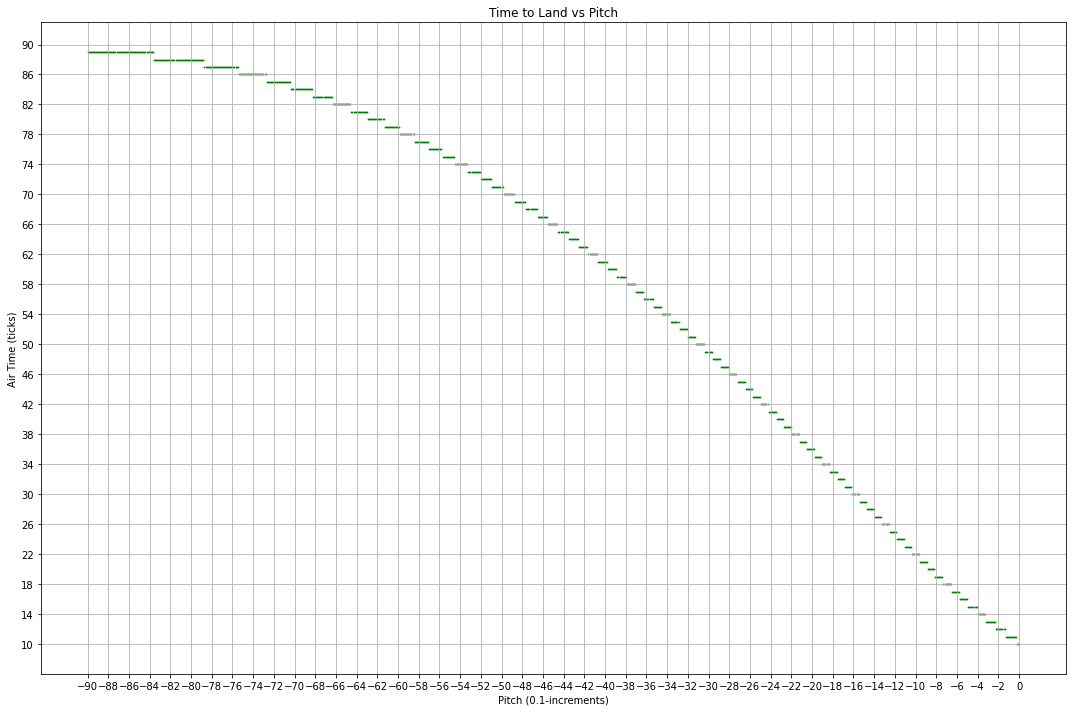

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(tf_2['Pitch'], tf_2['Airtime'], color=['green'], s=0.6)
plt.xticks(np.arange(-90, 0+0.1, 2))
plt.yticks(np.arange(10, 90+1, 4))
#plt.ylim(53, 62)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Air Time (ticks)')
plt.title('Time to Land vs Pitch')
plt.grid(True)
plt.tight_layout()


In [ ]:
### Now generate the float-precise dataset
landing_times_f = {}
landing_spots_z_f = {}
grain = 0.00000001 #0.00000001: -37.98 to -37.973683
for pitch in np.arange(-37.98, -37.973683, grain):
    landing_times_f[pitch] = (compute_landing_time(pitch))
    landing_spots_z_f[pitch] = s(landing_times_f[pitch], "z", pitch)
landing_spots_z_f, len(landing_spots_z_f)

({-37.98: 52.88795099506719,
  -37.979999989999996: 52.88795100227382,
  -37.979999979999995: 52.88795100948043,
  -37.979999969999994: 52.88795101668706,
  -37.979999959999994: 52.88795102389366,
  -37.97999994999999: 52.88795103110029,
  -37.97999993999999: 52.8879510383069,
  -37.97999992999999: 52.88795104551353,
  -37.97999991999999: 52.88795105272014,
  -37.97999990999999: 52.88795105992676,
  -37.97999989999999: 52.88795106713337,
  -37.97999988999999: 52.88795107434,
  -37.97999987999999: 52.88795108154661,
  -37.979999869999986: 52.88795108875324,
  -37.979999859999985: 52.88795109595984,
  -37.979999849999984: 52.887951103166465,
  -37.979999839999984: 52.88795111037308,
  -37.97999982999998: 52.887951117579696,
  -37.97999981999998: 52.88795112478632,
  -37.97999980999998: 52.887951131992935,
  -37.97999979999998: 52.88795113919955,
  -37.97999978999998: 52.88795114640617,
  -37.97999977999998: 52.88795115361279,
  -37.97999976999998: 52.887951160819405,
  -37.97999975999998

In [ ]:
top_entries_f = dict(sorted(landing_spots_z_f.items(), key=lambda item: item[1], reverse=True)[:100])
top_entries_f

{-37.97368379947739: 52.89250251748429,
 -37.97368380947739: 52.892502510278696,
 -37.973683819477394: 52.892502503073075,
 -37.973683829477395: 52.89250249586748,
 -37.973683839477395: 52.89250248866189,
 -37.973683849477396: 52.89250248145628,
 -37.9736838594774: 52.89250247425069,
 -37.9736838694774: 52.892502467045084,
 -37.9736838794774: 52.89250245983949,
 -37.9736838894774: 52.892502452633885,
 -37.9736838994774: 52.89250244542828,
 -37.9736839094774: 52.892502438222685,
 -37.9736839194774: 52.89250243101709,
 -37.9736839294774: 52.892502423811486,
 -37.973683939477404: 52.89250241660588,
 -37.973683949477405: 52.89250240940029,
 -37.973683959477405: 52.89250240219468,
 -37.973683969477406: 52.89250239498909,
 -37.97368397947741: 52.892502387783495,
 -37.97368398947741: 52.89250238057789,
 -37.97368399947741: 52.892502373372295,
 -37.97368400947741: 52.89250236616669,
 -37.97368401947741: 52.89250235896108,
 -37.97368402947741: 52.89250235175549,
 -37.97368403947741: 52.89250234

In [ ]:
df_f = pd.DataFrame.from_dict(top_entries_f, orient='index').reset_index()
df_f.columns = columns=['Pitch', 'Distance']
pd.options.display.float_format = '{:.14f}'.format
df_f = df_f.reset_index(drop = True)
df_f['Rank'] = range(1, 100+1)
df_f = df_f[['Rank', 'Pitch', 'Distance']]
df_f

,Rank,Pitch,Distance
0,1,-37.97368379947739,52.89250251748429
1,2,-37.97368380947739,52.89250251027870
2,3,-37.97368381947739,52.89250250307308
3,4,-37.97368382947739,52.89250249586748
4,5,-37.97368383947740,52.89250248866189
...,...,...,...
95,96,-37.97368474947747,52.89250183295229
96,97,-37.97368475947747,52.89250182574668
97,98,-37.97368476947747,52.89250181854108
98,99,-37.97368477947747,52.89250181133549


In [ ]:
### Write data to an excel with multiple tabs
with pd.ExcelWriter('pitch-vs-distance-results.xlsx', engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='0.1-grain', index=False)
    df_f.to_excel(writer, sheet_name='0.00000001-grain-top-100', index=False)

with pd.ExcelWriter('pitch-vs-airtime-results-zoomed-in.xlsx', engine='openpyxl') as writer:
    tf_2.to_excel(writer, sheet_name='pitch-vs-airtime', index=False)

# Vertical Wall Computations

In [ ]:
pitch_to_dist = dict(zip(df['Pitch'], df['Distance']))
pitch_to_dist

{-90.0: 0.076516,
 -89.9: 0.229548,
 -89.8: 0.38258,
 -89.7: 0.53561,
 -89.6: 0.688639,
 -89.5: 0.850167,
 -89.4: 1.003191,
 -89.3: 1.156212,
 -89.2: 1.309229,
 -89.1: 1.462243,
 -89.0: 1.623753,
 -88.9: 1.776757,
 -88.8: 1.929756,
 -88.7: 2.082749,
 -88.6: 2.235736,
 -88.5: 2.397215,
 -88.4: 2.550188,
 -88.3: 2.703153,
 -88.2: 2.85611,
 -88.1: 3.009059,
 -88.0: 3.170495,
 -87.9: 3.323425,
 -87.8: 3.476345,
 -87.7: 3.629254,
 -87.6: 3.790647,
 -87.5: 3.943533,
 -87.4: 4.096408,
 -87.3: 4.249271,
 -87.2: 4.402121,
 -87.1: 4.563449,
 -87.0: 4.716272,
 -86.9: 4.869081,
 -86.8: 5.021875,
 -86.7: 5.174654,
 -86.6: 5.335904,
 -86.5: 5.488651,
 -86.4: 5.641382,
 -86.3: 5.794096,
 -86.2: 5.946792,
 -86.1: 6.107953,
 -86.0: 6.260613,
 -85.9: 6.413254,
 -85.8: 6.565876,
 -85.7: 6.718478,
 -85.6: 6.879537,
 -85.5: 7.032098,
 -85.4: 7.184638,
 -85.3: 7.337156,
 -85.2: 7.489653,
 -85.1: 7.650597,
 -85.0: 7.803048,
 -84.9: 7.955475,
 -84.8: 8.107878,
 -84.7: 8.260257,
 -84.6: 8.421075,
 -84.5: 8.573

In [ ]:
d = 15
wall_landing_heights = []

grain = 0.1
for pitch in np.arange(-90, 0.001, grain):
    if d > pitch_to_dist[str(round(pitch, 1))]:
        #wall_landing_heights.append((pitch, 0))
        continue
    
    t = m.log(1 - d/(150*m.cos(m.radians(pitch)))) / m.log(0.99)
    wall_landing_heights.append((pitch, s(t, "y", pitch)))

wall_landing_heights

KeyError: '-90.0'

In [ ]:
print(f"Best angle to throw at given distance d={d} from wall:\n", max(wall_landing_heights, key=lambda x: x[1]))

Best angle to throw at given distance d=15 from wall:
 (-73.20000000000095, 32.248764269568085)


In [ ]:
wall_heights_df = pd.DataFrame(wall_landing_heights, columns=['Pitch', f'Attained Wall Height for d={d}'])
wall_heights_df

,Pitch,Attained Wall Height for d=15
0,-80.10000000000056,5.84556646659271
1,-80.00000000000057,7.32152911769808
2,-79.90000000000057,8.71444823155790
3,-79.80000000000058,10.02967705879968
4,-79.70000000000059,11.27214886245511
...,...,...
794,-0.70000000000508,4.25318315629494
795,-0.60000000000508,4.22706254757574
796,-0.50000000000509,4.20093324610199
797,-0.40000000000509,4.17479509368968


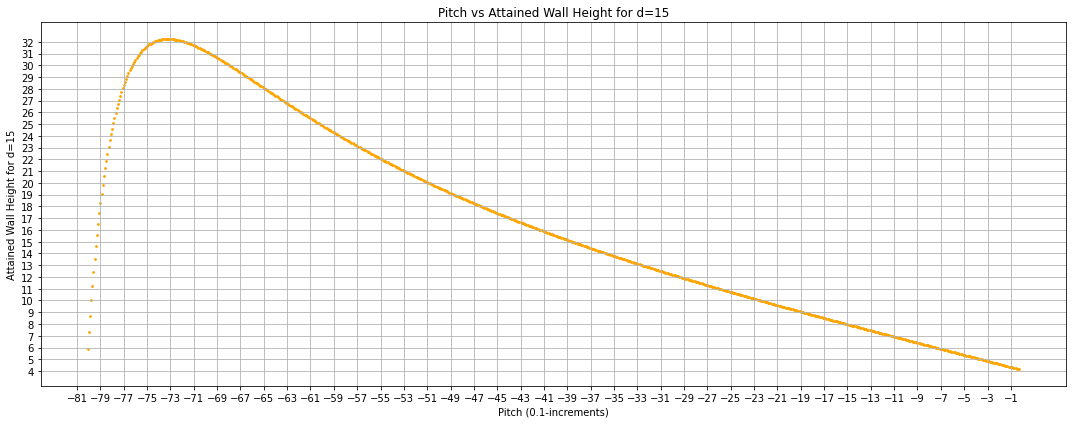

In [ ]:
plt.figure(figsize=(15,6))

plt.scatter(wall_heights_df['Pitch'], wall_heights_df[f'Attained Wall Height for d={d}'], color='orange', s=3)
plt.xticks(np.arange(m.floor(min(wall_heights_df['Pitch'])), m.ceil(max(wall_heights_df['Pitch']))+0.1, 2))
plt.yticks(np.arange(m.floor(min(wall_heights_df[f'Attained Wall Height for d={d}'])), m.ceil(max(wall_heights_df[f'Attained Wall Height for d={d}'])), 1))
#plt.ylim(53, 62)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel(f'Attained Wall Height for d={d}')
plt.title(f'Pitch vs Attained Wall Height for d={d}')
plt.grid(True)
plt.tight_layout()
